In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, scale
from sklearn import metrics as mt # mean_squared_error, confusion_matrix, roc_auc_score
from sklearn.neighbors import NearestNeighbors

Imports the cleaned data set (from HealthCost_data_cleaning notebook)

In [4]:
df=pd.read_csv('data/IPPS_Data_Clean.csv', \
               dtype={'provider_id':str,'provider_zip_code':str, 'drg_id':str,'total_discharges':float})

#df['provider_city_state'] = df.provider_city + ', ' + df.provider_state
df.head(3)

,drg_id,drg_definition,provider_id,provider_name,provider_street_address,provider_city,provider_state,provider_zip_code,hospital_referral_region_description,total_discharges,average_covered_charges,average_total_payments,average_medicare_payments
0,039,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91.0,32963.07,5777.24,4763.73
1,039,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14.0,15131.85,5787.57,4976.71
2,039,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24.0,37560.37,5434.95,4453.79


GPS locations of every unique provider.

In [5]:
dfprovgeo=pd.read_csv('data/Providers_Geocode.csv',usecols=['provider_id','lat','lng'],dtype={'provider_id':str})
dfprovgeo.head(3)

,provider_id,lat,lng
0,10001,31.216725,-85.363068
1,10005,34.221556,-86.159441
2,10006,34.793845,-87.683155


Percentage of uninsured by state (2013)

In [6]:
dfins = pd.read_csv('data/InsuranceCoverage_Adults19-64.csv',usecols=['Location','Uninsured'])#,encoding='Latin')
dfins=dfins[1:].reset_index(drop=True)#.head()

# Dataframe that lists states and their abbreviations for mapping
abbrev = pd.read_csv('data/states.csv').rename(columns={'State':'Location','Abbreviation':'provider_state'})
dfins = dfins.merge(abbrev,on ='Location')[['provider_state','Uninsured']]
dfins.head(3)

,provider_state,Uninsured
0,AL,0.22
1,AK,0.18
2,AZ,0.24


Population by state dataframe (Census.gov)

In [7]:
dfstates=pd.read_csv('data/NST-EST2015-alldata.csv',usecols=['NAME','POPESTIMATE2011'])#,dtype={'POPESTIMATE2011':float})
dfstates = dfstates[5:56].reset_index(drop=True)

# Dataframe that lists states and their abbreviations for mapping
abbrev = pd.read_csv('data/states.csv').rename(columns={'State':'NAME','Abbreviation':'provider_state'})

dfstates = dfstates.merge(abbrev,on ='NAME')
dfstates = dfstates[['provider_state','POPESTIMATE2011']]#,'RBIRTH2011','RDEATH2011']]
dfstates = dfstates.rename(columns={'POPESTIMATE2011':'state_population2011'})

dfstates.head(3)

,provider_state,state_population2011
0,AL,4801108
1,AK,722720
2,AZ,6468732


Population by zip code dataframe (http://notnullhypothesis.com/2010-census-data-by-zip-code-population/)

In [8]:
#dfzip = pd.read_csv('2010CensusPopulationData.csv',usecols=['Zip','Population'],dtype={'Zip':str})
dfzip = pd.read_csv('data/Zipcode-ZCTA-Population-Density-And-Area-Unsorted.csv', \
                   dtype={'Zip':str},usecols=['Zip','2010 Population','Density Per Sq Mile'])
dfzip.Zip = dfzip.Zip.str.zfill(5)
dfzip = dfzip.rename(columns = {'Zip':'provider_zip_code','2010 Population':'zip_population2010', \
                               'Density Per Sq Mile':'zip_pop2010_density'})
dfzip.head()

,provider_zip_code,zip_population2010,zip_pop2010_density
0,00601,0,0.0
1,00602,0,0.0
2,00603,0,0.0
3,00606,0,0.0
4,00610,0,0.0


Median income by zipcode (http://www.psc.isr.umich.edu/dis/census/Features/tract2zip/)

In [9]:
dfincome = pd.read_csv('data/MedianZIP-3.csv',dtype={'Zip':str},usecols=['Zip','Median'])

dfincome.Zip = dfincome.Zip.str.zfill(5)
dfincome.Median = dfincome.Median.str.replace(',','').astype(int)
dfincome = dfincome.rename(columns={'Zip':'provider_zip_code','Median':'zip_median_income'})

dfincome.head()

,provider_zip_code,zip_median_income
0,01001,56663
1,01002,49853
2,01003,28462
3,01005,75423
4,01007,79076


Combines all into one dataframe and selects the relevant columns

In [10]:
#df['provider_city_state'] = df.provider_city + ', ' + df.provider_state

dftot = df.merge(dfprovgeo, on='provider_id')
#dftot = dftot.merge(dfins,on='provider_state')
#dftot = dftot.merge(dfstates, on='provider_state')
#dftot = dftot.merge(dfzip, on='provider_zip_code',how='left')
#dftot = dftot.merge(dfcities, on=['provider_city_state'])
#dftot = dftot.merge(dfincome, on='provider_zip_code')
#dftot = dftot.drop([list(dftot.columns)[1]]+list(dftot.columns)[3:5]+list(dftot.columns)[11:13],axis=1)
#dftot.head()
#dftot.provider_id.nunique()
print(len(dftot))
dftot.head(3)

163065


,drg_id,drg_definition,provider_id,provider_name,provider_street_address,provider_city,provider_state,provider_zip_code,hospital_referral_region_description,total_discharges,average_covered_charges,average_total_payments,average_medicare_payments,lat,lng
0,039,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91.0,32963.07,5777.24,4763.73,31.216725,-85.363068
1,057,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,38.0,20312.78,4894.76,3865.50,31.216725,-85.363068
2,064,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,84.0,38820.39,10260.21,9167.08,31.216725,-85.363068


Calculates the national median cost for each procedure

In [11]:
natmed = pd.DataFrame(dftot.groupby('drg_id',sort=False).average_covered_charges.median()).reset_index()
natmed = natmed.rename(columns={'average_covered_charges':'median_covered_charges'})
natmed.head()

,drg_id,median_covered_charges
0,039,26651.00
1,057,20453.05
2,064,40953.59
3,065,25151.47
4,066,19976.00


Adds a column that is the fractional difference in total charges from the national median (for that particular procedure) and a column classifying whether the fractional difference is above (True) or below (False) the national median.

In [12]:
procedures=dftot.drg_id.unique()

for i in procedures:    
    med = natmed.loc[natmed.drg_id == i,'median_covered_charges'].iloc[0]
    dftot.loc[dftot.drg_id == i,'frac_diff'] = dftot.loc[dftot.drg_id == i,'average_covered_charges']/med - 1.0

dftot['frac_diff_class'] = dftot.frac_diff >= 0.0

dftot.head(3)

,drg_id,drg_definition,provider_id,provider_name,provider_street_address,provider_city,provider_state,provider_zip_code,hospital_referral_region_description,total_discharges,average_covered_charges,average_total_payments,average_medicare_payments,lat,lng,frac_diff,frac_diff_class
0,039,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91.0,32963.07,5777.24,4763.73,31.216725,-85.363068,0.236842,True
1,057,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,38.0,20312.78,4894.76,3865.50,31.216725,-85.363068,-0.006858,False
2,064,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,84.0,38820.39,10260.21,9167.08,31.216725,-85.363068,-0.052088,False


In [13]:
dftot.groupby('frac_diff_class').size()

frac_diff_class
False    81506
True     81559
dtype: int64

For each provider, calculates the number of other providers within a 40 mile radius (Takes around 3.5 minutes to run)

In [14]:
from geopy.distance import vincenty
import time

In [15]:
%%time
dfprovgeo['n_hosp'] = 0.0

pts = [dfprovgeo.lat,dfprovgeo.lng]
pts = list(list(x) for x in zip(*pts))
i=0

for index, row in dfprovgeo[['lat','lng']].iterrows():
    count = 0
    pt1 = [row.lat,row.lng]
    
    for pt in pts:
        dist = vincenty(pt1, pt).miles
        if dist < 40 and dist > 0:
            count +=1
            
    dfprovgeo.loc[index,'n_hosp'] = count
    i+=1
    if i % 1000 == 0: print(i)

1000
2000
3000
CPU times: user 3min 44s, sys: 8 ms, total: 3min 44s
Wall time: 3min 44s


In [16]:
dfprovgeo.head()

,provider_id,lat,lng,n_hosp
0,10001,31.216725,-85.363068,6.0
1,10005,34.221556,-86.159441,8.0
2,10006,34.793845,-87.683155,8.0
3,10011,33.596457,-86.667650,12.0
4,10016,33.252444,-86.813555,11.0


In [17]:
dftot = dftot.merge(dfprovgeo[['provider_id','n_hosp']], on='provider_id')

In [18]:
dftot.head(3)

,drg_id,drg_definition,provider_id,provider_name,provider_street_address,provider_city,provider_state,provider_zip_code,hospital_referral_region_description,total_discharges,average_covered_charges,average_total_payments,average_medicare_payments,lat,lng,frac_diff,frac_diff_class,n_hosp
0,039,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91.0,32963.07,5777.24,4763.73,31.216725,-85.363068,0.236842,True,6.0
1,057,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,38.0,20312.78,4894.76,3865.50,31.216725,-85.363068,-0.006858,False,6.0
2,064,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,84.0,38820.39,10260.21,9167.08,31.216725,-85.363068,-0.052088,False,6.0


Random Forest Classifier using entire dataset trying to predict whether a given procedure at a provider will be above or below the national median.

Selects the variables for X and y for the random forest classifier.

In [19]:
inx = ['lat','lng']#'provider_city']#,'zip_pop2010_density','zip_population2010','zip_median_income']#,'provider_id']#['lat','lng']#
dfX = dftot.loc[:,inx]#zip_population2010']]
dfY = dftot.loc[:,'frac_diff_class']

dfX.head()

,lat,lng
0,31.216725,-85.363068
1,31.216725,-85.363068
2,31.216725,-85.363068
3,31.216725,-85.363068
4,31.216725,-85.363068


In [ ]:
# dfX = pd.get_dummies(dfX, columns=['drg_id'], dummy_na=True)
# dfX.head()

Does the test-train split and runs the RFC on the training set. It then calculates the R^2 score using the model to predict the test set.

In [20]:
rf = RandomForestClassifier(n_jobs=-1)
#rf.n_estimators=10

X_train, X_test, y_train, y_test = train_test_split(dfX, dfY, train_size=2./3)

rf.fit(X_train,y_train)

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

rf.score(X_test,y_test)

0.87577959709318365

In [21]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    tick_label = ['f < 0','f > 0']
    plt.xticks(tick_marks, tick_label, rotation=45)
    plt.yticks(tick_marks, tick_label)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Plots the confusion matrix comparing the predicted label to the true label.

Confusion matrix
[[23754  3327]
 [ 3425 23849]]
Normalized confusion matrix
[[ 0.87714634  0.12285366]
 [ 0.12557747  0.87442253]]


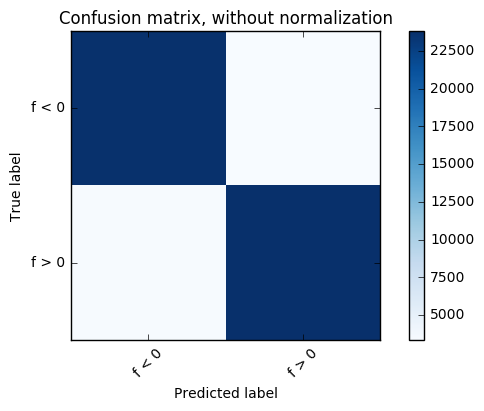

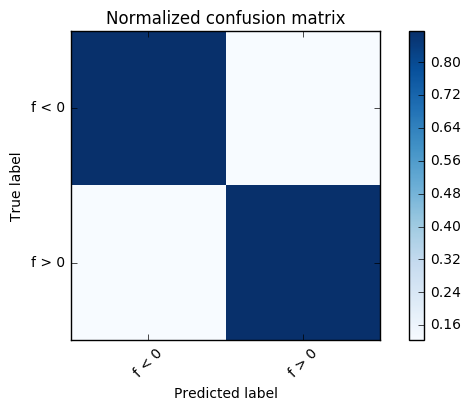

In [22]:
cm = mt.confusion_matrix(y_test, y_test_pred)

print('Confusion matrix')
print(cm)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)


plt.figure()
plot_confusion_matrix(cm,title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

Plots the ROC curve and calculates the AUC score for the RFR model.

AUC Score = 0.949496112679


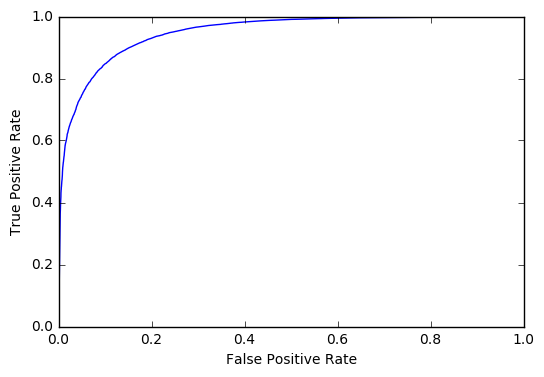

In [23]:
y_score = rf.predict_proba(X_test)[:,1]

print('AUC Score =',mt.roc_auc_score(y_test, y_score))
fpr, tpr, thresholds = mt.roc_curve(y_test,y_score)
plt.figure()
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

Adding in other variables such as the population and median income by zip code seemed to have no significant effect. I also calculated the number of other providers within 40 miles of each provider, but adding that variable had no effect as well.

I also found that I get the same results with just the provider_id tag as the input X using pandas’ get_dummies to convert the variable to an indicator variable rather than numerical value. This makes me think that the GPS coordinates are essentially acting as an indicator for the specific provider rather than giving any useful information as far as relative position to other hospitals.